In [1]:
%run imports.ipynb

In [5]:
cell_line_info = pd.read_csv('../note2/results/CCLE/sample_info.csv')
aml_cell_line_info = cell_line_info[(cell_line_info.primary_disease == 'Leukemia') & (cell_line_info.Subtype.str.contains('AML'))]

sra_run_table = pd.read_csv('../note2/results/CCLE/SraRunTable_SRP186687.txt')
sra_run_table = sra_run_table[sra_run_table['Assay Type'] == 'Bisulfite-Seq']

sra_run_table['Cell_Line'] = sra_run_table.Cell_Line.str.upper().str.replace('-', '').str.replace(' ', '').str.replace('.', '').str.replace('/' ,'')

/data/project/dohoon/miniconda3/envs/dnmt3a/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  import sys


In [7]:
cellline_name2depmap_id = {r['stripped_cell_line_name']: r['DepMap_ID'] for r in aml_cell_line_info.to_records()}

In [8]:
run2cellline = {r.Run:r.Cell_Line for r in sra_run_table.to_records()}

In [9]:
aml_cell_line_info.shape

(54, 26)

In [12]:
aml_rrbs_run_table = sra_run_table[sra_run_table.Cell_Line.isin(aml_cell_line_info.stripped_cell_line_name)]

In [14]:
runs = aml_rrbs_run_table.Run.values
len(runs)

34

In [15]:
methyldackel_fps = [f'/data2/project/SNUH_DNMT3A/pipelines/CCLE-RRBS/result/03_methyldackel/{run}_CpG.bedGraph' for run in runs]
len(methyldackel_fps)

34

In [26]:
pair_fp = f'/data3/project/SNUH_DNMT3A/pipelines/METHEOR/result/CCLE-RRBS/'

NameError: name 'pair_fp' is not defined

### Genomewide

In [19]:
beta_summary = defaultdict(list)

for run in tqdm(runs):
    concordance_fp = f'/data2/project/SNUH_DNMT3A/pipelines/CCLE-RRBS/result/05_concordance_full/{run}_concordance.csv'
    methyldackel_fp = f'../note2/results/CCLE-FINAL/filtered_bedgraphs/{run}_CpG.filtered.bedGraph'
    
    concordance_df = pd.read_csv(concordance_fp)
    
    # Maintain a set of CpGs that participated in computing concordances.
    cpg_set = set()
    for pair in concordance_df.to_records():
        cpg_set.add(f'{pair.chrom}:{pair.pos1}')
        cpg_set.add(f'{pair.chrom}:{pair.pos2}')
    
    bedgraph = read_bedgraph(methyldackel_fp)
    bedgraph['cpg_id'] = bedgraph['chrom'] + ':' + bedgraph['start'].astype(str)
    
    bedgraph = bedgraph[bedgraph.cpg_id.isin(cpg_set)]
    
    beta_summary['run'].append(run)
    beta_summary['beta'].append(bedgraph.beta.mean())
    
beta_summary = pd.DataFrame(beta_summary)

100%|██████████| 34/34 [04:04<00:00,  7.21s/it]


In [22]:
beta_summary['cell_line'] = beta_summary.run.map(run2cellline)
beta_summary['depmap_id'] = beta_summary.cell_line.map(cellline_name2depmap_id)

### Bivalent domain

In [27]:
beta_summary = defaultdict(list)

for run in tqdm(runs):
    concordance_fp = f'/data2/project/SNUH_DNMT3A/pipelines/CCLE-RRBS/result/05_concordance_full/{run}_concordance.csv'
    methyldackel_fp = f'/data2/project/SNUH_DNMT3A/pipelines/CCLE-RRBS/result/03_methyldackel_bivalent_domain/{run}_CpG.filtered.bedGraph'
    
    concordance_df = pd.read_csv(concordance_fp)
    
    # Maintain a set of CpGs that participated in computing concordances.
    cpg_set = set()
    for pair in concordance_df.to_records():
        cpg_set.add(f'{pair.chrom}:{pair.pos1}')
        cpg_set.add(f'{pair.chrom}:{pair.pos2}')
    
    bedgraph = read_bedgraph(methyldackel_fp)
    bedgraph['cpg_id'] = bedgraph['chrom'] + ':' + bedgraph['start'].astype(str)
    
    bedgraph = bedgraph[bedgraph.cpg_id.isin(cpg_set)]
    
    beta_summary['run'].append(run)
    beta_summary['beta'].append(bedgraph.beta.mean())
    
beta_summary = pd.DataFrame(beta_summary)

100%|██████████| 34/34 [00:57<00:00,  1.70s/it]


In [30]:
beta_summary['cell_line'] = beta_summary.run.map(run2cellline)
beta_summary['depmap_id'] = beta_summary.cell_line.map(cellline_name2depmap_id)

In [31]:
beta_summary.to_csv('source_data/ccle_bivalent_domain_beta_summary.csv', index=False)

In [35]:
ctrp_per_cpd_avg = pd.read_csv('../note2/results/CCLE/v20.meta.per_assay_plate.txt', sep='\t')

ctrp_cell_lines = pd.read_csv('../note2/results/CCLE/v20.meta.per_cell_line.txt', sep='\t')
ctrp_compounds = pd.read_csv('../note2/results/CCLE/v20.meta.per_compound.txt', sep='\t')
ctrp_experiments = pd.read_csv('../note2/results/CCLE/v20.meta.per_experiment.txt', sep='\t')

master_ccl_id2ccl_name = {r.master_ccl_id:r.ccl_name for r in ctrp_cell_lines.to_records()}
master_cpd_id2cpd_name = {r.master_cpd_id:r.cpd_name for r in ctrp_compounds.to_records()}

ctrp_curves = pd.read_csv('../note2/results/CCLE/v20.data.curves_post_qc.txt', sep='\t').merge(ctrp_experiments, on='experiment_id')
ctrp_curves['ccl_name'] = ctrp_curves.master_ccl_id.map(master_ccl_id2ccl_name)
ctrp_curves['cpd_name'] = ctrp_curves.master_cpd_id.map(master_cpd_id2cpd_name)

In [38]:
ccl_names = set(ctrp_curves.ccl_name.str.upper())
m3_ccl_names = aml_cell_line_info[(aml_cell_line_info.lineage_sub_subtype == 'M3') | (aml_cell_line_info.lineage_sub_subtype.isnull())].stripped_cell_line_name.values

ctrp_ccl_names = [ccl.upper() for ccl in beta_summary.cell_line.unique() if pd.notnull(ccl) and (ccl.replace('-', '') in ccl_names) and (ccl.replace('-', '') not in m3_ccl_names)]

In [39]:
d = beta_summary.groupby('cell_line').agg({'beta': 'mean'}).reset_index()

ctrp_beta_map = {r.cell_line.replace('-', ''):r.beta for r in d.to_records() if pd.notnull(r.cell_line)}
ctrp_curves['beta'] = ctrp_curves.ccl_name.map(ctrp_beta_map)

ctrp_curves_aml_beta = ctrp_curves[ctrp_curves.ccl_name.isin(ctrp_ccl_names)].copy()

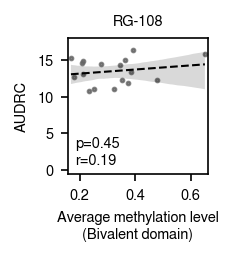

<Figure size 225x225 with 0 Axes>

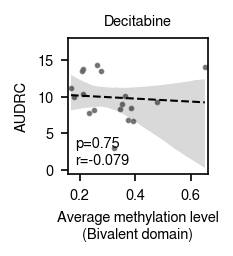

<Figure size 225x225 with 0 Axes>

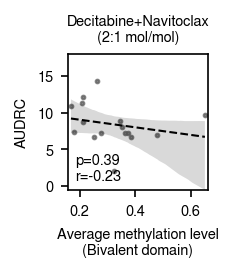

<Figure size 225x225 with 0 Axes>

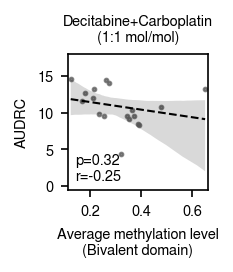

<Figure size 225x225 with 0 Axes>

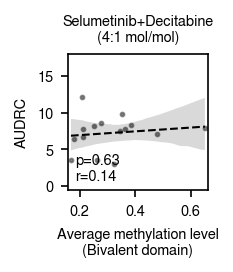

<Figure size 225x225 with 0 Axes>

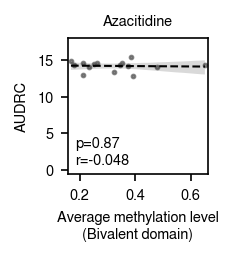

<Figure size 225x225 with 0 Axes>

In [42]:
from scipy.stats import linregress

drugs = ['RG-108', 'decitabine', 'decitabine:navitoclax (2:1 mol/mol)', 'decitabine:carboplatin (1:1 mol/mol)', 'selumetinib:decitabine (4:1 mol/mol)', 
                          'azacitidine']

drugs_short = ['RG108', 'decitabine', 'decitabine_navitoclax_2_1', 'decitabine_carboplatin_1_1', 'selumetinib_decitabine_4_1', 'azacitidine']
drugs_title = [
    'RG-108',
    'Decitabine',
    'Decitabine+Navitoclax\n(2:1 mol/mol)',
    'Decitabine+Carboplatin\n(1:1 mol/mol)',
    'Selumetinib+Decitabine\n(4:1 mol/mol)',
    'Azacitidine',
]

for i, (drug, drug_short, drug_title) in enumerate(zip(drugs, drugs_short, drugs_title)):
    fig = plt.figure(figsize=(1.2, 1.2))

    ax = fig.add_subplot(111)

    d = ctrp_curves_aml_beta[ctrp_curves_aml_beta.cpd_name == drug].drop_duplicates('ccl_name')
    sns.regplot(x=d['beta'], y=d['area_under_curve'], scatter_kws={'s': 3, 'color': '0.4'}, line_kws={'lw': 1, 'ls': '--', 'color': 'k'}, ax=ax)
    
    ax.set_xlim([d.beta.min() - 1e-2, d.beta.max() + 1e-2])
    ax.set_ylim([-0.5, 18])

    result = linregress(d['beta'], d['area_under_curve'])
    ax.text(0.05, 0.05, f'p={result.pvalue:.2g}\nr={result.rvalue:.2g}', ha='left', va='bottom', transform=ax.transAxes)

    ax.set_xlabel('Average methylation level\n(Bivalent domain)')
    ax.set_ylabel('AUDRC')
    
    ax.set_title(drug_title, fontsize=7)
    
    save_figures(f'source_data_figures/hma_response_beta/bivalent_domain_beta.{drug_short}')

    plt.show()
    plt.clf()

In [29]:
beta_summary

,run,beta
0,SRR8633223,0.322212
1,SRR8633235,0.211678
2,SRR8633289,0.651328
3,SRR8633442,0.590878
4,SRR8633517,0.377001
5,SRR8633548,0.391251
6,SRR8633588,0.178001
7,SRR8633592,0.212716
8,SRR8633609,0.261398
9,SRR8633676,0.168552
